In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.optimizers import Adam

from gpu.negfc_models import get_model_new
from gpu.losses import reduce_std
from gpu.data import load_data

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%%time
root='./data/fake/'
dataset, cube_shp, init_xy, init_flux = load_data(root)

CPU times: user 17 s, sys: 5.01 s, total: 22 s
Wall time: 10.5 s


In [6]:
model = get_model_new(init_xy, init_flux, cube_shp)
model.compile(loss_fn=reduce_std, optimizer=Adam(5))

In [7]:
%%time
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=20,
)
hist = model.fit(dataset, epochs=100000, callbacks=[es])

Epoch 1/100000
1/1 [==============================] - 2s 2s/step - loss: 0.6363
Epoch 2/100000
1/1 [==============================] - 1s 891ms/step - loss: 0.6253
Epoch 3/100000
1/1 [==============================] - 1s 880ms/step - loss: 0.6142
Epoch 4/100000
1/1 [==============================] - 1s 890ms/step - loss: 0.6033
Epoch 5/100000
1/1 [==============================] - 1s 884ms/step - loss: 0.5924
Epoch 6/100000
1/1 [==============================] - 1s 880ms/step - loss: 0.5815
Epoch 7/100000
1/1 [==============================] - 1s 913ms/step - loss: 0.5707
Epoch 8/100000
1/1 [==============================] - 1s 883ms/step - loss: 0.5600
Epoch 9/100000
1/1 [==============================] - 1s 884ms/step - loss: 0.5494
Epoch 10/100000
1/1 [==============================] - 1s 886ms/step - loss: 0.5389
Epoch 11/100000
1/1 [==============================] - 1s 884ms/step - loss: 0.5284
Epoch 12/100000
1/1 [==============================] - 1s 909ms/step - loss: 0.5180
Epoc

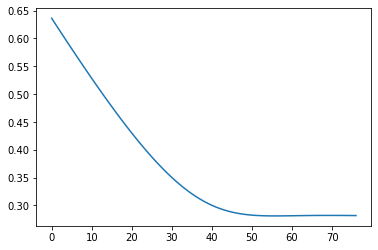

In [8]:
plt.plot(hist.history['loss'])

In [17]:
x_fguess = model.trainable_variables[0]
y_fguess = model.trainable_variables[1]
f_fguess = model.trainable_variables[2]
f_fguess

<tf.Variable 'MoveScale/flux:0' shape=(1, 1) dtype=float32, numpy=array([[-228.11752]], dtype=float32)>

In [10]:
import gpu.fake_comp as tfnegfc

from main import open_fits

In [13]:
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 
# cube = cube[None,...]
psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (80, 1023, 1023)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


In [14]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

In [15]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

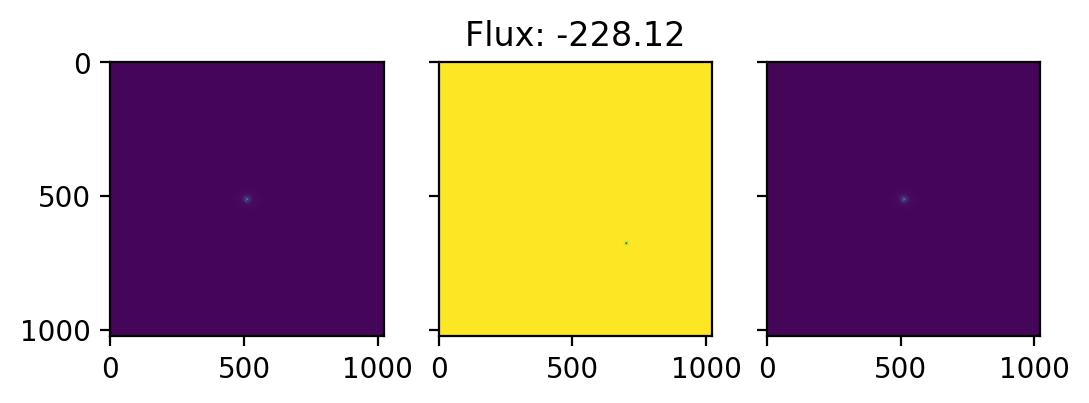

In [36]:
import numpy as np
for x_firstguess, y_firstguess, flux_firstguess in zip(x_fguess, y_fguess, f_fguess):

    fake_zeros = tfnegfc.inject_fake(x=x_firstguess, 
                                     y=y_firstguess, 
                                     flux = flux_firstguess, 
                                     cube=tf.zeros_like(cube[0]), 
                                     patch=patch, 
                                     rot_angles=rot_ang)

#     adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
#                                        rot_ang, 
#                                        out_size=(cube[0].shape),
#                                        ncomp=1, 
#                                        derotate='tf')

#     adi_image, res_cube = tfnegfc.apply_adi(cube[0], 
#                                             rot_ang, 
#                                             out_size=cube[0].shape, 
#                                             ncomp=1, 
#                                             derotate='tf', return_cube=True)

    fig, axes = plt.subplots(1, 3, dpi=200, sharex=True, sharey=True)
    axes[0].imshow(cube[0, 0])
    axes[1].imshow(fake_zeros[0])
    axes[2].imshow(cube[0, 0]-fake_zeros[0])
    axes[1].set_title('Flux: {:.2f}'.format(flux_firstguess[0]))
    plt.show()
